In [1]:
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
from tqdm import tqdm 
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import os
import seaborn as sns
import psutil

2025-05-29 00:58:27.630990: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748480308.058144      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748480308.176326      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data preprocessing

In [2]:
class DataProcessor:
    def __init__(self, data_path=None):
        self.data_path = data_path or '/kaggle/input/cic-ids2018/' 
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.non_numeric_cols = ['Timestamp', 'Flow ID', 'Source IP', 'Destination IP',
                                'Source Port', 'Destination Port', 'Protocol']
        self.valid_labels = {
            'BENIGN', 'DoS Hulk', 'PortScan', 'DDoS', 'FTP-Patator',
            'DoS GoldenEye', 'DoS Slowloris', 'SSH-Patator', 'Web Attack',
            'Bot', 'Brute Force-Web', 'Brute Force-XSS', 'SQL Injection',
            'Infiltration', 'DDOS-LOIC-HTTP', 'DDOS-HOIC', 'SSH-Bruteforce',
            'FTP-Bruteforce', 'DDoS-LOIC-UDP'
        }
        self.label_aliases = {
            'benign': 'BENIGN', 'benign': 'BENIGN', 'BENIGN': 'BENIGN',  
            'ddos': 'DDoS',
            'portscan': 'PortScan',
            'ftp-patator': 'FTP-Patator',
            'dos attacks-hulk': 'DoS Hulk',
            'dos attacks-slowloris': 'DoS Slowloris',
            'brute force -web': 'Brute Force-Web',
            'ddos attack-loic-http': 'DDOS-LOIC-HTTP',
            'ssh-bruteforce': 'SSH-Bruteforce',
            'bot': 'Bot',
            'sql injection': 'SQL Injection',
            'infilteration': 'Infiltration'
        }

    def load_data(self):
        files = [f for f in os.listdir(self.data_path) if f.endswith('.csv')][:5]
        dfs = []
        chunk_size = 100000  # adjusted based on my notebook, paper uses around 2x i think
        
        for file in tqdm(files, desc="Loading files"):
            try:
                # Read in chunks
                chunks = []
                for chunk in pd.read_csv(os.path.join(self.data_path, file),
                                       dtype={'Flow ID': str, 'Source IP': str, 'Destination IP': str,
                                              'Source Port': 'category', 'Destination Port': 'category',
                                              'Protocol': 'category'},
                                       chunksize=chunk_size, low_memory=False):
                    # Process each chunk
                    chunk.columns = chunk.columns.str.strip().str.replace(' ', '').str.title()
                    label_col = next((col for col in chunk.columns if 'label' in col.lower()), None)
                    
                    if label_col:
                        chunk[label_col] = chunk[label_col].astype(str).str.strip().str.upper()
                        chunk[label_col] = chunk[label_col].replace(
                            {k.upper(): v for k, v in self.label_aliases.items()}
                        )
                        valid_mask = chunk[label_col].isin(self.valid_labels)
                        if valid_mask.any():
                            chunk = chunk[valid_mask].copy()
                            chunk = chunk.rename(columns={label_col: 'Label'})
                            chunks.append(chunk)
                
                if chunks:
                    df = pd.concat(chunks, ignore_index=True)
                    dfs.append(df)
                else:
                    print(f"Skipping {file} - no valid data")

            except Exception as e:
                print(f"Skipping {file} due to error: {str(e)}")
                continue

        if not dfs:
            raise ValueError("No valid data files found. Check dataset contents.")

        full_df = pd.concat(dfs, axis=0)
        return full_df

    def preprocess(self, df):
        df['Timestamp'] = pd.to_datetime(
            df['Timestamp'], 
            format='%d/%m/%Y %H:%M:%S',
            dayfirst=True,
            errors='coerce'
        )
        df = df.dropna(subset=['Timestamp'])
        df['TimeWindow'] = (df['Timestamp'].dt.minute // 5) * 5
        numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
        numeric_cols = [col for col in numeric_cols if col != 'Label']        
        time_features = df.groupby('TimeWindow')[numeric_cols].agg(['mean', 'std']).reset_index()
        time_features.columns = ['_'.join(col).strip() if col[1] else col[0] 
                                for col in time_features.columns.values]
        time_features = time_features.rename(columns={'TimeWindow_': 'TimeWindow'})
        df = df.drop(columns=self.non_numeric_cols, errors='ignore')
        for col in df.columns:
            if col != 'Label':
                df[col] = pd.to_numeric(df[col], errors='coerce', downcast='float')
        df = df.replace([np.inf, -np.inf], np.nan)
        df = df.dropna(axis=1, how='all')
        df = df.dropna()
        df = df.drop_duplicates()
        df = pd.merge(df, time_features, on='TimeWindow', how='left')        
        if df.select_dtypes(include=np.number).replace([np.inf, -np.inf], np.nan).isna().any().any():
            raise ValueError("Data contains invalid values after preprocessing")
        valid_labels = df['Label'].unique()
        if 'BENIGN' not in valid_labels:
            raise ValueError("Dataset missing BENIGN label")

        df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

        # Feature scaling
        features = df.drop('Label', axis=1)
        labels = df['Label']
        scaled_features = self.scaler.fit_transform(features)

        return scaled_features, labels

In [3]:
processor = DataProcessor('/kaggle/input/ids-intrusion-csv')
df = processor.load_data()
df.head()

Loading files: 100%|██████████| 5/5 [01:12<00:00, 14.53s/it]


,Dstport,Protocol,Timestamp,Flowduration,Totfwdpkts,Totbwdpkts,Totlenfwdpkts,Totlenbwdpkts,Fwdpktlenmax,Fwdpktlenmin,...,Fwdsegsizemin,Activemean,Activestd,Activemax,Activemin,Idlemean,Idlestd,Idlemax,Idlemin,Label
0,443,6,28/02/2018 08:22:13,94658,6,7,708,3718,387,0,...,20,0,0,0,0,0,0,0,0,BENIGN
1,443,6,28/02/2018 08:22:13,206,2,0,0,0,0,0,...,20,0,0,0,0,0,0,0,0,BENIGN
2,445,6,28/02/2018 08:22:15,165505,3,1,0,0,0,0,...,20,0,0,0,0,0,0,0,0,BENIGN
3,443,6,28/02/2018 08:22:16,102429,6,7,708,3718,387,0,...,20,0,0,0,0,0,0,0,0,BENIGN
4,443,6,28/02/2018 08:22:16,167,2,0,0,0,0,0,...,20,0,0,0,0,0,0,0,0,BENIGN


In [4]:
df_important = df.copy()

In [5]:
df = df_important.copy()
df = df.sample(50000)
for col in df.columns:
    if col in ['Timestamp', 'Label']:
        continue
    df[col] = df[col].apply(lambda x: float(x))

# Model Training

DataFrame 'df' found. Proceeding with the provided DataFrame.

--- Initial Exploratory Data Analysis ---
DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 49127 to 451914
Data columns (total 80 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Dstport         50000 non-null  float64
 1   Protocol        50000 non-null  float64
 2   Timestamp       50000 non-null  object 
 3   Flowduration    50000 non-null  float64
 4   Totfwdpkts      50000 non-null  float64
 5   Totbwdpkts      50000 non-null  float64
 6   Totlenfwdpkts   50000 non-null  float64
 7   Totlenbwdpkts   50000 non-null  float64
 8   Fwdpktlenmax    50000 non-null  float64
 9   Fwdpktlenmin    50000 non-null  float64
 10  Fwdpktlenmean   50000 non-null  float64
 11  Fwdpktlenstd    50000 non-null  float64
 12  Bwdpktlenmax    50000 non-null  float64
 13  Bwdpktlenmin    50000 non-null  float64
 14  Bwdpktlenmean   50000 non-null  float64
 15  

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


             Dstport      Protocol            Timestamp  Flowduration  \
count   50000.000000  50000.000000                50000  5.000000e+04   
unique           NaN           NaN                22552           NaN   
top              NaN           NaN  16/02/2018 01:45:28           NaN   
freq             NaN           NaN                  147           NaN   
mean    17619.747440      8.227060                  NaN  9.201719e+06   
std     24455.616275      4.555221                  NaN  2.723519e+07   
min         0.000000      0.000000                  NaN  0.000000e+00   
25%        80.000000      6.000000                  NaN  9.400000e+02   
50%       443.000000      6.000000                  NaN  2.004650e+04   
75%     48750.000000      6.000000                  NaN  4.082247e+06   
max     65531.000000     17.000000                  NaN  1.200000e+08   

          Totfwdpkts    Totbwdpkts  Totlenfwdpkts  Totlenbwdpkts  \
count   50000.000000  50000.000000     50000.0000   5.0

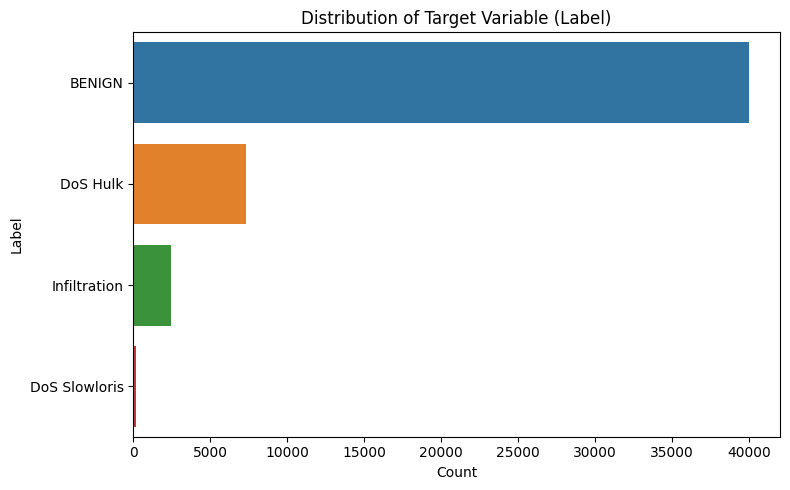


--- Data Preprocessing ---
Standardized column names. Current columns: ['Dst Port', 'Protocol', 'Timestamp', 'Flowduration', 'Totfwdpkts']...
Dropped 'Timestamp' column.
Initial number of features: 78
No non-numeric columns found that require conversion.
Infinity values found and replaced with NaN in 2 column(s).
NaN values found. Filling with column medians for numeric or a placeholder for object types.
  Filled 246 NaNs in numeric column 'Flowbyts/S' with median: 317.91
  Filled 246 NaNs in numeric column 'Flowpkts/S' with median: 142.08
All remaining features are numeric.
Labels encoded. 4 classes: ['BENIGN', 'DoS Hulk', 'DoS Slowloris', 'Infiltration'] -> [0, 1, 2, 3]
Data split: X_train shape (35000, 78), X_test shape (15000, 78), y_train shape (35000,), y_test shape (15000,)


/tmp/ipykernel_19/1170781075.py:204: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipykernel_19/1170781075.py:204: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

Features scaled using StandardScaler.

--- Feature Selection using Decision Tree ---


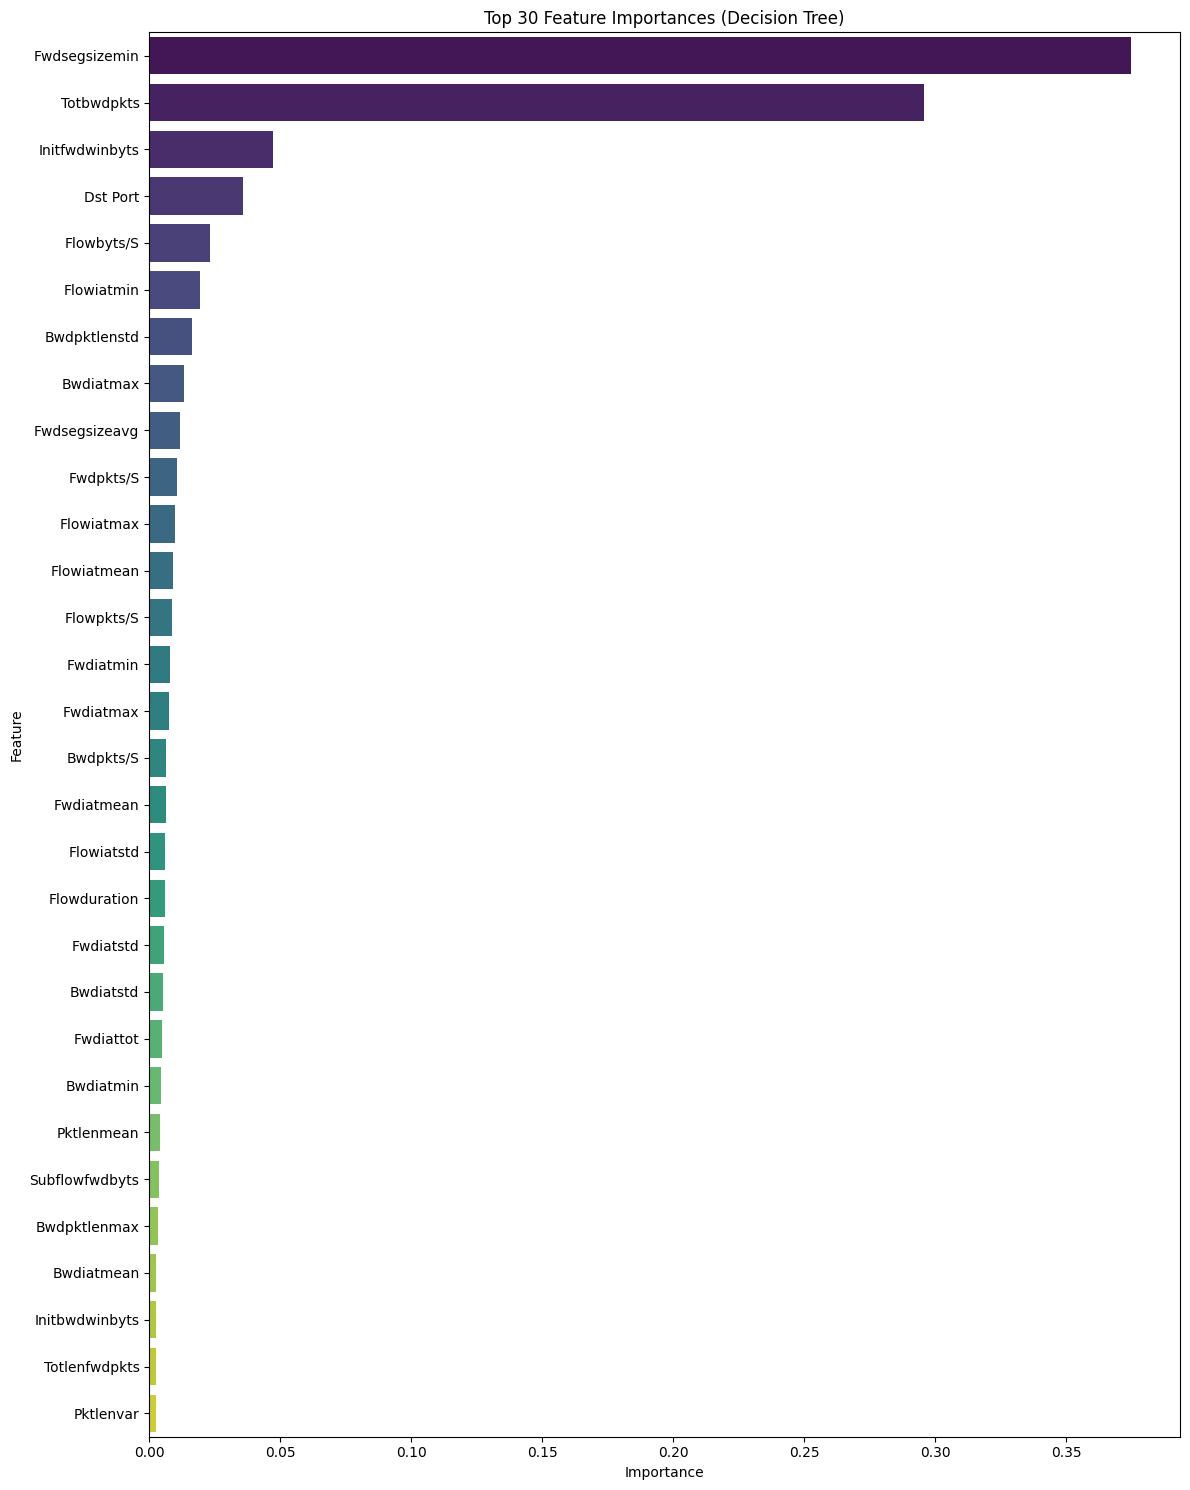

Top 30 features selected. First 5: ['Fwdsegsizemin', 'Totbwdpkts', 'Initfwdwinbyts', 'Dst Port', 'Flowbyts/S']...
Data dimensions after feature selection: X_train_selected shape (35000, 30), X_test_selected shape (15000, 30)

--- Correlation Heatmap of Selected Features ---


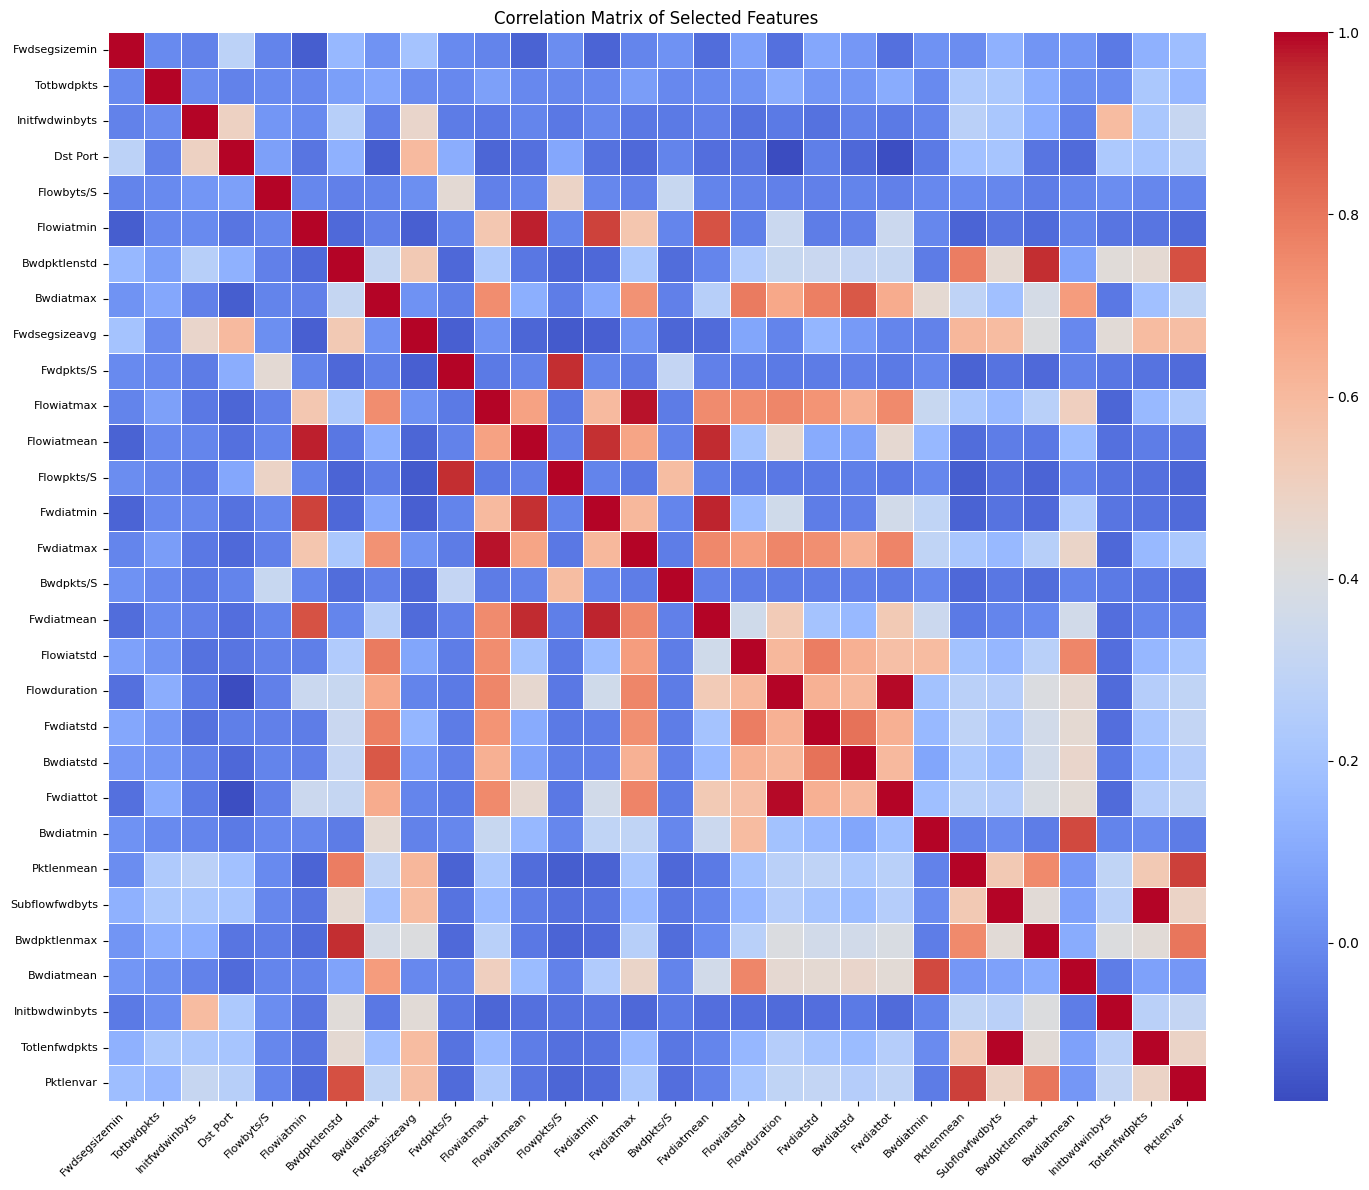


--- Deep Neural Network (DNN) for Classification ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1748480433.565831      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748480433.566440      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Training DNN model...


I0000 00:00:1748480437.369931      68 service.cc:148] XLA service 0x7b1fe000c050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748480437.371517      68 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748480437.371535      68 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748480437.722367      68 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748480439.826257      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 3.
DNN model training complete.


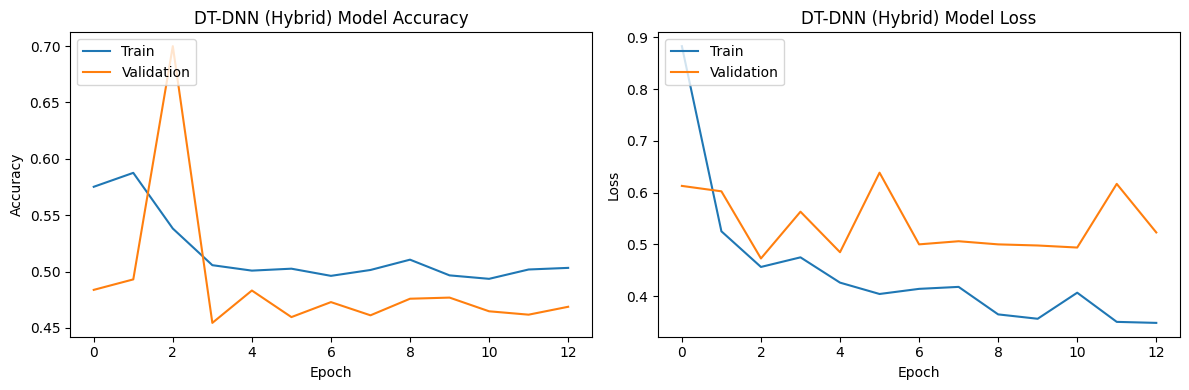

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

--- DT-DNN (Hybrid) Performance ---
  Accuracy: 0.6979
  Prec_weighted: 0.9196
  Rec_weighted: 0.6979
  F1_weighted: 0.7760
  Prec_macro: 0.5810
  Rec_macro: 0.7912
  F1_macro: 0.5911
  Kappa: 0.4296
  MCC: 0.5092
  AUC_weighted: 0.9253
  AUC_macro: 0.9066

Classification Report (DT-DNN (Hybrid)):
               precision    recall  f1-score   support

       BENIGN       0.96      0.65      0.78     12008
     DoS Hulk       0.98      0.99      0.99      2196
DoS Slowloris       0.29      0.96      0.44        56
 Infiltration       0.09      0.56      0.16       740

     accuracy                           0.70     15000
    macro avg       0.58      0.79      0.59     15000
 weighted avg       0.92      0.70      0.78     15000



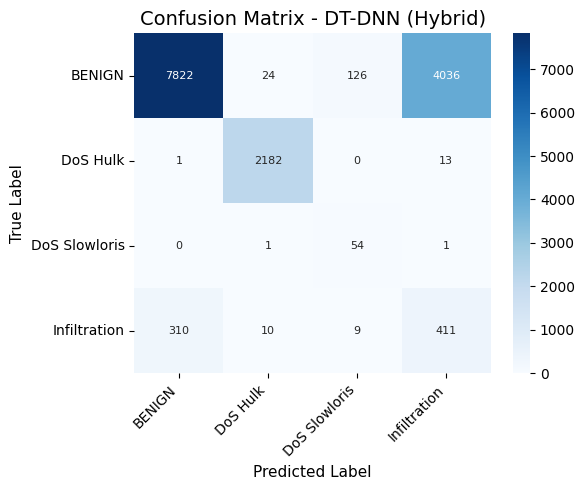

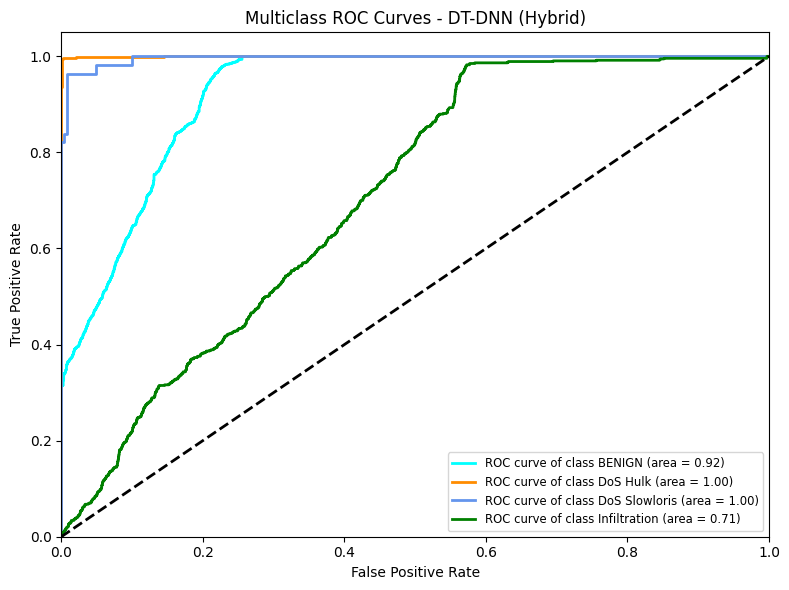


--- Random Forest Classifier ---

--- Random Forest Performance ---
  Accuracy: 0.9437
  Prec_weighted: 0.9252
  Rec_weighted: 0.9437
  F1_weighted: 0.9321
  Prec_macro: 0.8181
  Rec_macro: 0.7738
  F1_macro: 0.7854
  Kappa: 0.8200
  MCC: 0.8246
  AUC_weighted: 0.9437
  AUC_macro: 0.9349

Classification Report (Random Forest):
               precision    recall  f1-score   support

       BENIGN       0.95      0.98      0.97     12008
     DoS Hulk       1.00      1.00      1.00      2196
DoS Slowloris       1.00      0.98      0.99        56
 Infiltration       0.32      0.13      0.19       740

     accuracy                           0.94     15000
    macro avg       0.82      0.77      0.79     15000
 weighted avg       0.93      0.94      0.93     15000



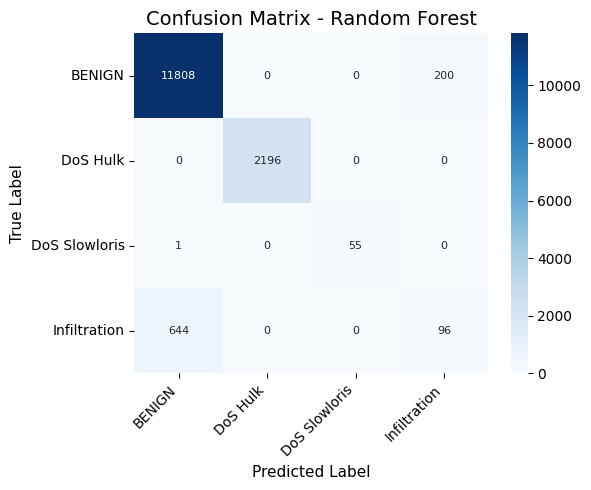

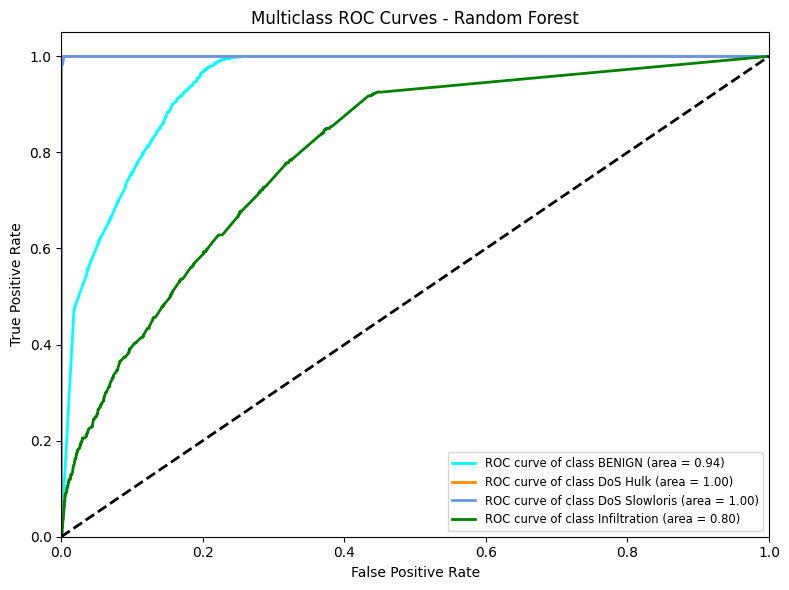


--- Support Vector Machine (SVM) Classifier ---

--- SVM Performance ---
  Accuracy: 0.5433
  Prec_weighted: 0.9429
  Rec_weighted: 0.5433
  F1_weighted: 0.6405
  Prec_macro: 0.6310
  Rec_macro: 0.8301
  F1_macro: 0.5960
  Kappa: 0.3200
  MCC: 0.4745
  AUC_weighted: 0.9337
  AUC_macro: 0.9179

Classification Report (SVM):
               precision    recall  f1-score   support

       BENIGN       0.99      0.44      0.60     12008
     DoS Hulk       0.99      1.00      1.00      2196
DoS Slowloris       0.45      0.98      0.62        56
 Infiltration       0.09      0.90      0.16       740

     accuracy                           0.54     15000
    macro avg       0.63      0.83      0.60     15000
 weighted avg       0.94      0.54      0.64     15000



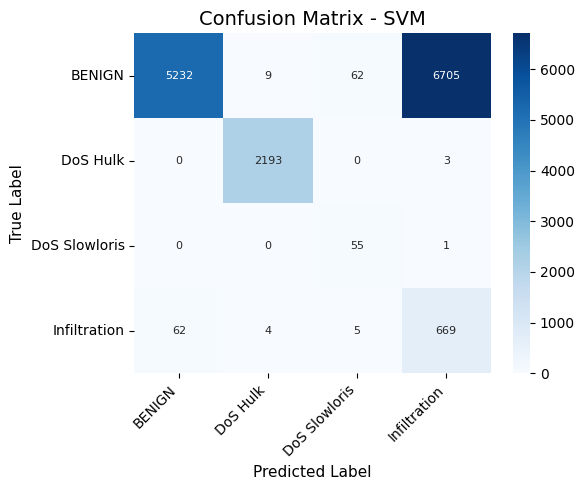


--- Logistic Regression Classifier ---

--- Logistic Regression Performance ---
  Accuracy: 0.5299
  Prec_weighted: 0.9340
  Rec_weighted: 0.5299
  F1_weighted: 0.6281
  Prec_macro: 0.6185
  Rec_macro: 0.8104
  F1_macro: 0.5819
  Kappa: 0.3054
  MCC: 0.4568
  AUC_weighted: 0.9279
  AUC_macro: 0.9154

Classification Report (Logistic Regression):
               precision    recall  f1-score   support

       BENIGN       0.98      0.42      0.59     12008
     DoS Hulk       0.99      1.00      0.99      2196
DoS Slowloris       0.42      0.98      0.59        56
 Infiltration       0.08      0.84      0.15       740

     accuracy                           0.53     15000
    macro avg       0.62      0.81      0.58     15000
 weighted avg       0.93      0.53      0.63     15000



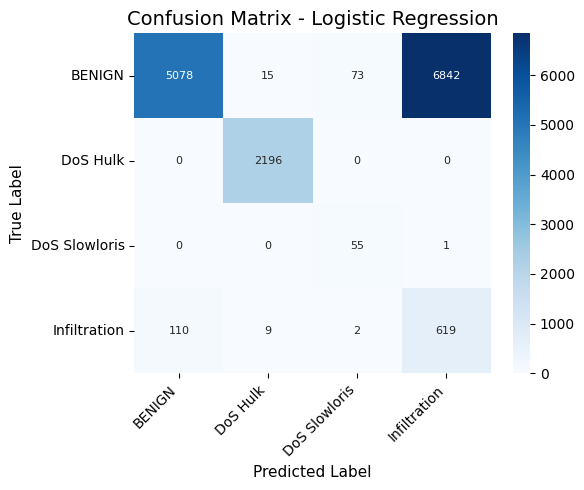


--- K-Nearest Neighbors (KNN) Classifier ---

--- K-Nearest Neighbors Performance ---
  Accuracy: 0.9453
  Prec_weighted: 0.9223
  Rec_weighted: 0.9453
  F1_weighted: 0.9300
  Prec_macro: 0.8057
  Rec_macro: 0.7410
  F1_macro: 0.7556
  Kappa: 0.8222
  MCC: 0.8294
  AUC_weighted: 0.9169
  AUC_macro: 0.8961

Classification Report (K-Nearest Neighbors):
               precision    recall  f1-score   support

       BENIGN       0.95      0.99      0.97     12008
     DoS Hulk       1.00      1.00      1.00      2196
DoS Slowloris       0.96      0.89      0.93        56
 Infiltration       0.32      0.08      0.13       740

     accuracy                           0.95     15000
    macro avg       0.81      0.74      0.76     15000
 weighted avg       0.92      0.95      0.93     15000



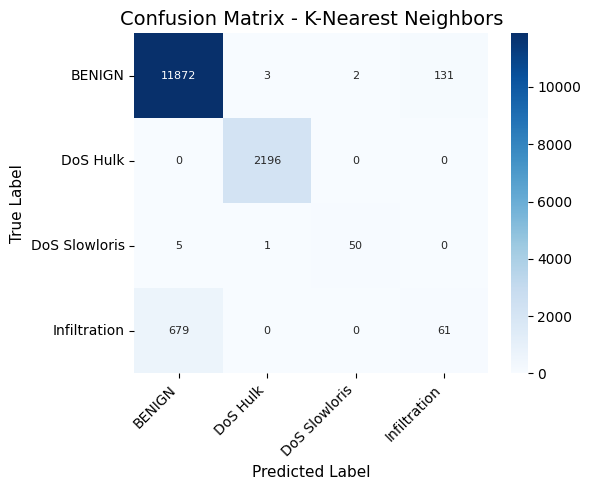


--- Gradient Boosting Classifier ---

--- Gradient Boosting Performance ---
  Accuracy: 0.9493
  Prec_weighted: 0.9254
  Rec_weighted: 0.9493
  F1_weighted: 0.9297
  Prec_macro: 0.8312
  Rec_macro: 0.7464
  F1_macro: 0.7527
  Kappa: 0.8323
  MCC: 0.8435
  AUC_weighted: 0.9514
  AUC_macro: 0.9415

Classification Report (Gradient Boosting):
               precision    recall  f1-score   support

       BENIGN       0.94      1.00      0.97     12008
     DoS Hulk       1.00      1.00      1.00      2196
DoS Slowloris       0.98      0.95      0.96        56
 Infiltration       0.40      0.04      0.08       740

     accuracy                           0.95     15000
    macro avg       0.83      0.75      0.75     15000
 weighted avg       0.93      0.95      0.93     15000



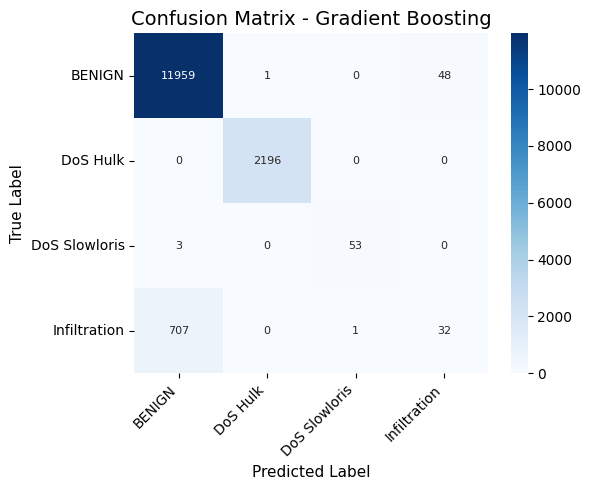


--- AdaBoost Classifier ---

--- AdaBoost Performance ---
  Accuracy: 0.4150
  Prec_weighted: 0.9091
  Rec_weighted: 0.4150
  F1_weighted: 0.5047
  Prec_macro: 0.6220
  Rec_macro: 0.5174
  F1_macro: 0.3947
  Kappa: 0.2238
  MCC: 0.3927
  AUC_weighted: 0.4738
  AUC_macro: 0.7387

Classification Report (AdaBoost):
               precision    recall  f1-score   support

       BENIGN       0.95      0.29      0.44     12008
     DoS Hulk       0.97      1.00      0.99      2196
DoS Slowloris       0.50      0.02      0.03        56
 Infiltration       0.06      0.76      0.11       740

     accuracy                           0.41     15000
    macro avg       0.62      0.52      0.39     15000
 weighted avg       0.91      0.41      0.50     15000



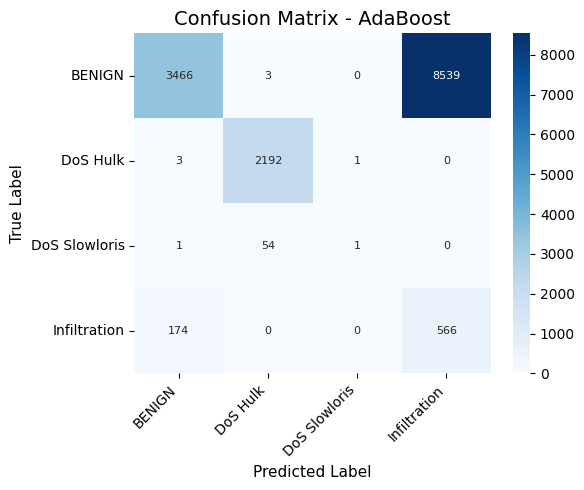


--- XGBoost Classifier ---

--- XGBoost Performance ---
  Accuracy: 0.7107
  Prec_weighted: 0.9397
  Rec_weighted: 0.7107
  F1_weighted: 0.7873
  Prec_macro: 0.7746
  Rec_macro: 0.8523
  F1_macro: 0.7456
  Kappa: 0.4600
  MCC: 0.5524
  AUC_weighted: 0.9522
  AUC_macro: 0.9455

Classification Report (XGBoost):
               precision    recall  f1-score   support

       BENIGN       0.98      0.65      0.78     12008
     DoS Hulk       1.00      1.00      1.00      2196
DoS Slowloris       1.00      0.98      0.99        56
 Infiltration       0.12      0.77      0.21       740

     accuracy                           0.71     15000
    macro avg       0.77      0.85      0.75     15000
 weighted avg       0.94      0.71      0.79     15000



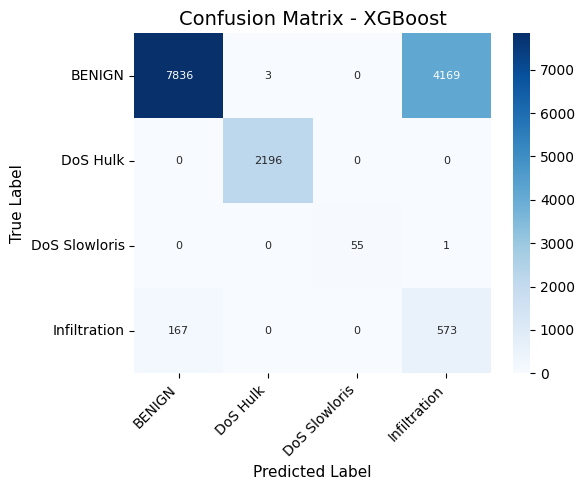

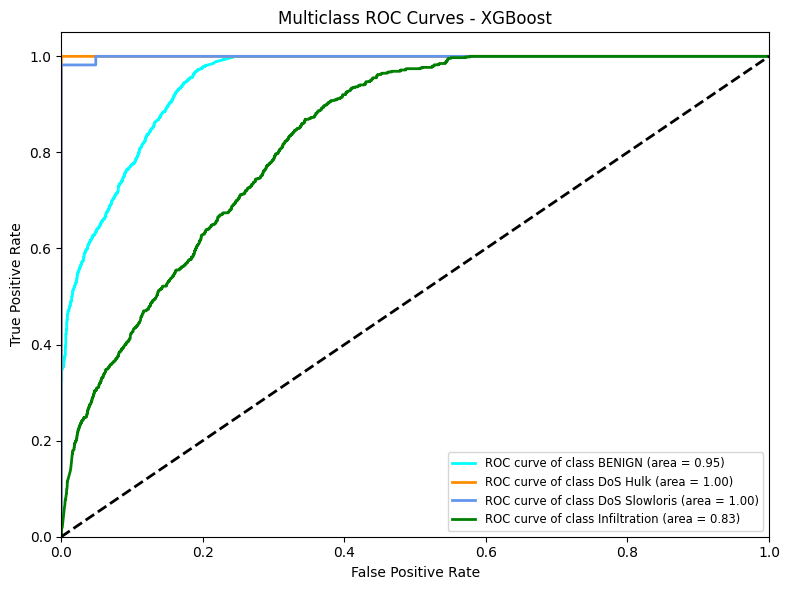


--- CatBoost Classifier ---

--- CatBoost Performance ---
  Accuracy: 0.6476
  Prec_weighted: 0.9437
  Rec_weighted: 0.6476
  F1_weighted: 0.7361
  Prec_macro: 0.7374
  Rec_macro: 0.8548
  F1_macro: 0.7076
  Kappa: 0.4030
  MCC: 0.5236
  AUC_weighted: 0.9490
  AUC_macro: 0.9408

Classification Report (CatBoost):
               precision    recall  f1-score   support

       BENIGN       0.99      0.57      0.72     12008
     DoS Hulk       0.99      1.00      1.00      2196
DoS Slowloris       0.86      0.98      0.92        56
 Infiltration       0.11      0.87      0.20       740

     accuracy                           0.65     15000
    macro avg       0.74      0.85      0.71     15000
 weighted avg       0.94      0.65      0.74     15000



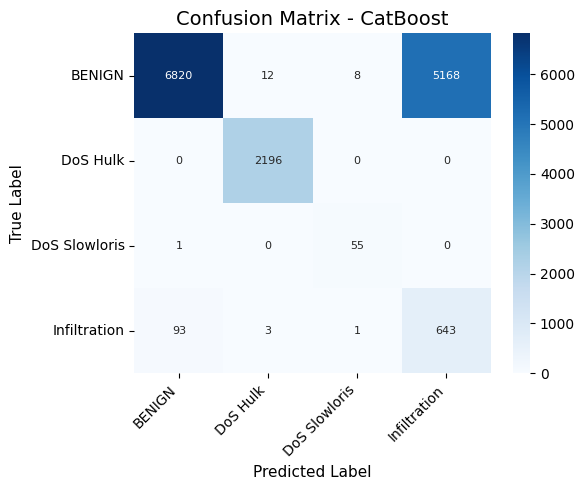


--- LightGBM Classifier ---
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7234
[LightGBM] [Info] Number of data points in the train set: 35000, number of used features: 30
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

--- LightGBM Performance ---
  Accuracy: 0.8341
  Prec_weighted: 0.9434
  Rec_weighted: 0.8341
  F1_weighted: 0.8747
  Prec_macro: 0.7922
  Rec_macro: 0.8788
  F1_macro: 0.7946
  Kappa: 0.6224
  MCC: 0.6644
  AUC_weighted: 0.9666
  AUC

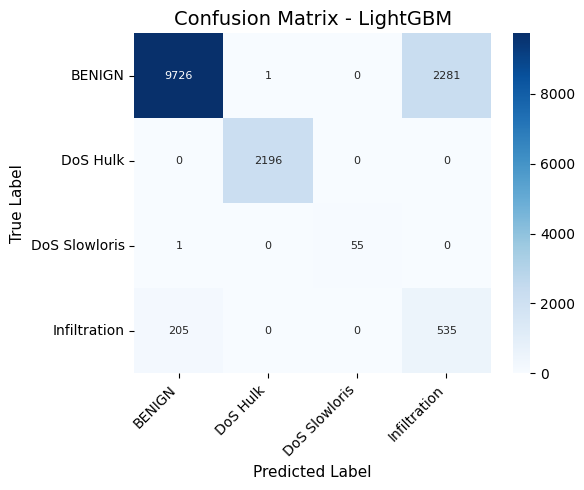


--- Summary Comparison Table of Model Performances ---
          Algorithm  Accuracy  Prec_weighted  Prec_macro  Rec_weighted  Rec_macro  F1_weighted  F1_macro  AUC_weighted  AUC_macro  Kappa    MCC
    DT-DNN (Hybrid)    0.6979         0.9196      0.5810        0.6979     0.7912       0.7760    0.5911        0.9253     0.9066 0.4296 0.5092
      Random Forest    0.9437         0.9252      0.8181        0.9437     0.7738       0.9321    0.7854        0.9437     0.9349 0.8200 0.8246
                SVM    0.5433         0.9429      0.6310        0.5433     0.8301       0.6405    0.5960        0.9337     0.9179 0.3200 0.4745
Logistic Regression    0.5299         0.9340      0.6185        0.5299     0.8104       0.6281    0.5819        0.9279     0.9154 0.3054 0.4568
K-Nearest Neighbors    0.9453         0.9223      0.8057        0.9453     0.7410       0.9300    0.7556        0.9169     0.8961 0.8222 0.8294
  Gradient Boosting    0.9493         0.9254      0.8312        0.9493     0.746

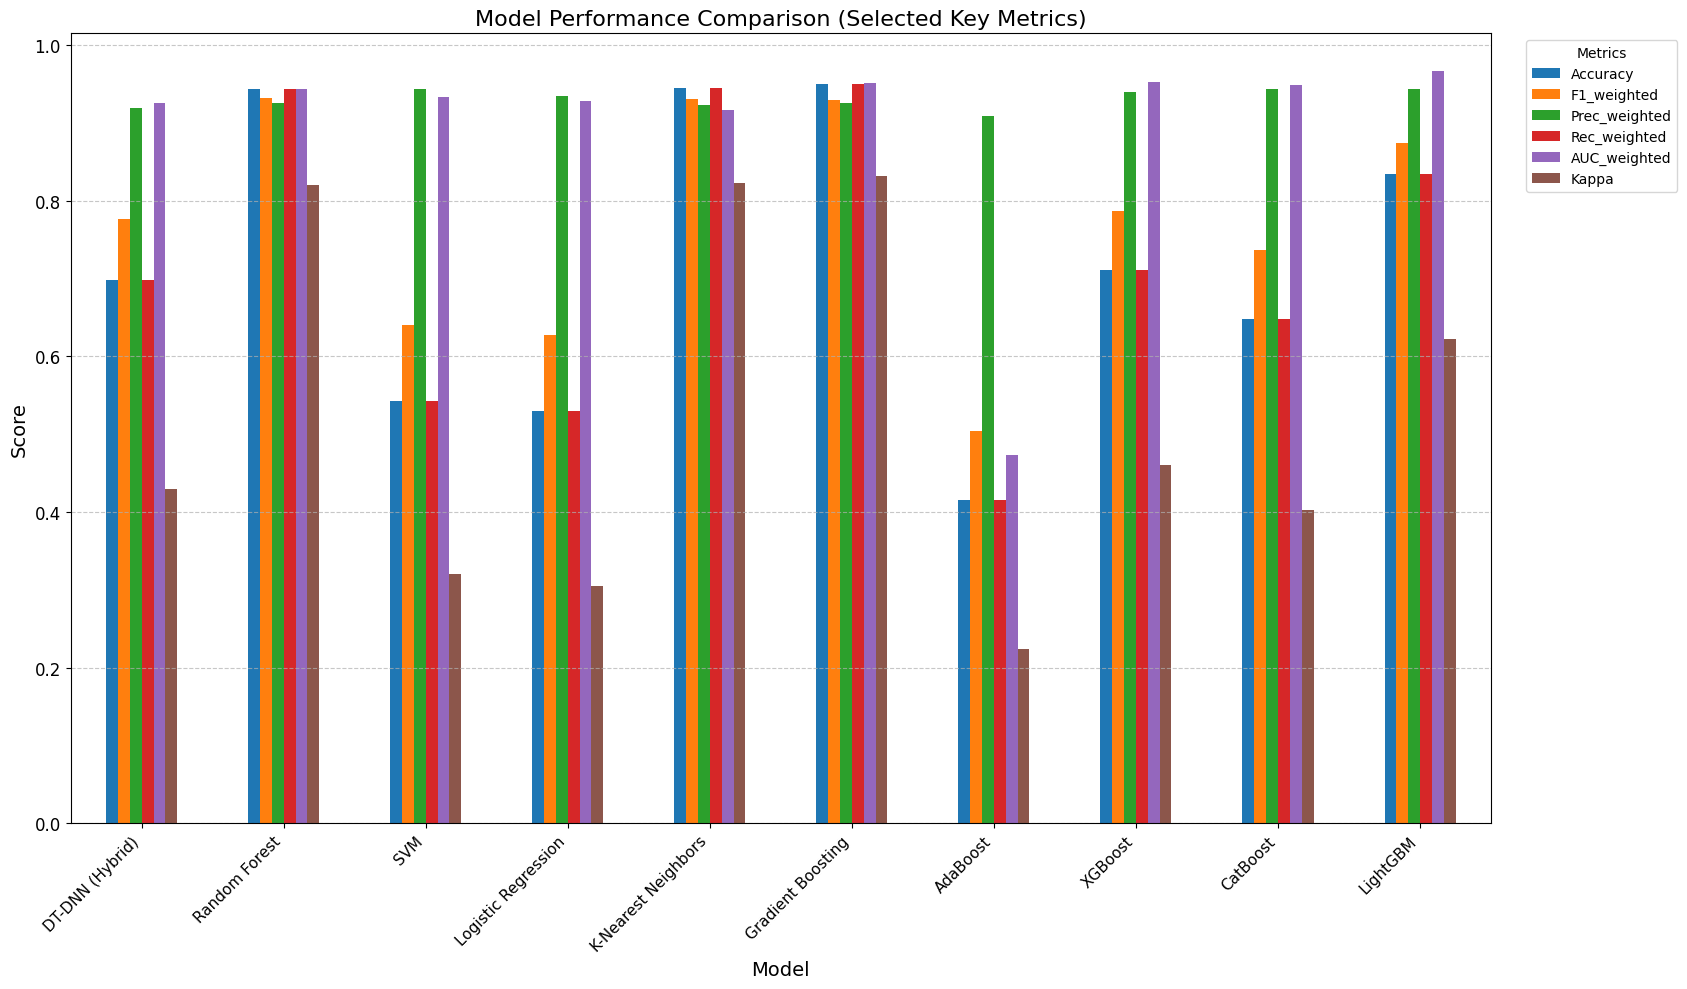


--- Script Execution Finished ---

Key Considerations for Real-World Application:
1.  Dataset Specific Preprocessing: Real IoT datasets demand meticulous cleaning. Handle IP addresses, ports, timestamps, and categorical features (like protocol names) with domain-specific logic. Consider cyclical encoding for time-based features if 'Timestamp' is used.
2.  Hyperparameter Tuning: Employ systematic tuning (GridSearchCV, RandomizedSearchCV, Optuna, KerasTuner) for all models. Default parameters are rarely optimal.
3.  Advanced Imbalance Handling: Beyond class/sample weights, explore oversampling (SMOTE, ADASYN), undersampling (Tomek Links, NearMiss), or hybrid approaches. For DNNs, focal loss can be effective.
4.  Feature Engineering: Create new features from existing ones (e.g., flow duration/packet count, ratios, interaction terms). This often yields significant performance gains.
5.  Robust Cross-Validation: Use StratifiedKFold for classification to ensure class proportions are maintai

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support, roc_auc_score, roc_curve, auc,
                             classification_report, confusion_matrix, cohen_kappa_score, matthews_corrcoef)
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_sample_weight # For XGBoost sample_weight
from itertools import cycle


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Import new classifiers
try:
    from xgboost import XGBClassifier
except ImportError:
    print("XGBoost not found. Please install it: pip install xgboost")
    XGBClassifier = None # Placeholder
try:
    from catboost import CatBoostClassifier
except ImportError:
    print("CatBoost not found. Please install it: pip install catboost")
    CatBoostClassifier = None # Placeholder
try:
    from lightgbm import LGBMClassifier
except ImportError:
    print("LightGBM not found. Please install it: pip install lightgbm")
    LGBMClassifier = None # Placeholder


import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
N_FEATURES_TO_SELECT = 30
TEST_SIZE = 0.3
RANDOM_STATE = 42
DNN_EPOCHS = 50 # Keep low for faster demo
DNN_BATCH_SIZE = 32
DNN_VALIDATION_SPLIT = 0.2
DNN_PATIENCE = 10
LR_MAX_ITER = 1000
KNN_N_NEIGHBORS = 5
XGB_N_ESTIMATORS = 100
XGB_LEARNING_RATE = 0.1
CATBOOST_ITERATIONS = 100 # Keep low for faster demo
CATBOOST_LEARNING_RATE = 0.1
LGBM_N_ESTIMATORS = 100
LGBM_LEARNING_RATE = 0.1
ADABOOST_N_ESTIMATORS = 50
ADABOOST_LEARNING_RATE = 1.0

# --- DataFrame Loading/Mocking ---
# Assume 'df' is pre-loaded as per the user's description.
# For demonstration, let's create a mock DataFrame if df is not available.
try:
    df.head()
    print("DataFrame 'df' found. Proceeding with the provided DataFrame.")
except NameError:
    print("DataFrame 'df' not found. Creating a mock DataFrame for demonstration purposes.")
    print("Please ensure your actual 'df' is loaded for real analysis.")
    n_samples = 2000
    n_features = 78 # Total features including DstPort, Protocol, excluding Label, Timestamp
    
    # Create base numeric features
    data = np.random.rand(n_samples, n_features - 2) * 100 
    
    # Create specific mock features that might be problematic or categorical-like
    int_data1 = np.random.randint(0, 1000, size=(n_samples, 1)) # Mock 'Dst Port'
    int_data2 = np.random.choice([6, 17, 1, 0], size=(n_samples, 1)) # Mock 'Protocol'
    
    all_feature_data = np.concatenate([data, int_data1, int_data2], axis=1)
    
    # Create feature names, ensuring 'Dst Port' and 'Protocol' are present
    base_feature_names = [f'feature_{i+1}' for i in range(n_features - 2)]
    feature_columns = base_feature_names + ['Dst Port', 'Protocol']
    np.random.shuffle(feature_columns) # Shuffle to mimic real-world unordered columns

    df_features = pd.DataFrame(all_feature_data, columns=feature_columns)
    
    df_features['Timestamp'] = pd.to_datetime(pd.date_range(start='1/1/2020', periods=n_samples, freq='S'))
    labels = ['BENIGN', 'Infiltration', 'DoS Hulk', 'DoS Slowloris', 'PortScan']
    df_features['Label'] = np.random.choice(labels, n_samples, p=[0.55, 0.1, 0.15, 0.1, 0.1]) # Adjusted probabilities

    df = df_features
    # df.rename(columns={'DstPort': 'Dst Port', 'Protocol': 'Protocol'}, inplace=True, errors='ignore') # Already handled by naming

    print("Mock DataFrame created with shape:", df.shape)
    print("Mock DataFrame columns:", df.columns.tolist())
    print("Mock DataFrame Label distribution:\n", df['Label'].value_counts())
    if 'Label' not in df.columns or 'Timestamp' not in df.columns:
        raise ValueError("Mock DataFrame creation failed to include 'Label' or 'Timestamp'.")

    # Ensure exactly 78 features (excluding Label, Timestamp)
    current_feature_cols = [col for col in df.columns if col not in ['Label', 'Timestamp']]
    feature_cols_count = len(current_feature_cols)

    if feature_cols_count != 78:
        print(f"Adjusting mock DataFrame to have 78 features. Current: {feature_cols_count}")
        if feature_cols_count < 78:
            for i in range(78 - feature_cols_count):
                df[f'mock_added_feature_{i}'] = np.random.rand(n_samples)
        elif feature_cols_count > 78:
            cols_to_drop = current_feature_cols[78:]
            df = df.drop(columns=cols_to_drop)
        print(f"Adjusted mock DataFrame to have 78 features. New shape: {df.shape}")


# --- Initial Exploratory Data Analysis (EDA) ---
print("\n--- Initial Exploratory Data Analysis ---")
print("DataFrame Info:")
df.info(verbose=True, show_counts=True)

print("\nDescriptive Statistics (Original Data):")
print(df.describe(include='all'))

if 'Label' in df.columns:
    print("\nTarget Variable Distribution:")
    print(df['Label'].value_counts())
    plt.figure(figsize=(8, 5))
    sns.countplot(y=df['Label'], order = df['Label'].value_counts().index)
    plt.title('Distribution of Target Variable (Label)')
    plt.xlabel('Count')
    plt.ylabel('Label')
    plt.tight_layout()
    plt.show()
else:
    print("Warning: 'Label' column not found for EDA.")


# --- Data Preprocessing ---
print("\n--- Data Preprocessing ---")

# Standardize column names
column_name_mapping = {
    ' Destination Port': 'Dst Port', 'Dstport': 'Dst Port', ' Destinationport': 'Dst Port',
    'Flow Duration': 'Flow Duration', # Example, add more as needed
}
df.columns = df.columns.str.strip() # Remove leading/trailing whitespace from all column names
df.rename(columns=column_name_mapping, inplace=True, errors='ignore') # errors='ignore' if some mappings don't exist
print(f"Standardized column names. Current columns: {df.columns.tolist()[:5]}...")


# Drop Timestamp
if 'Timestamp' in df.columns:
    df_processed = df.drop('Timestamp', axis=1)
    print("Dropped 'Timestamp' column.")
else:
    df_processed = df.copy()
    print("'Timestamp' column not found, proceeding without dropping.")

if 'Label' not in df_processed.columns:
    raise ValueError("'Label' column not found in the DataFrame after initial processing steps.")

# Separate features (X) and target (y)
y = df_processed['Label']
X = df_processed.drop('Label', axis=1)
original_feature_names = X.columns.tolist()
print(f"Initial number of features: {X.shape[1]}")

# Convert non-numeric columns to numeric, coercing errors
numeric_cols_before_conversion = X.select_dtypes(include=np.number).columns.tolist()
non_numeric_cols = X.select_dtypes(exclude=np.number).columns.tolist()

if len(non_numeric_cols) > 0:
    print(f"Non-numeric columns found: {non_numeric_cols}. Attempting conversion to numeric.")
    for col in non_numeric_cols:
        # Attempt conversion, count NaNs before and after to see effect
        nans_before = X[col].isnull().sum()
        X[col] = pd.to_numeric(X[col], errors='coerce')
        nans_after = X[col].isnull().sum()
        if nans_after > nans_before:
            print(f"  Column '{col}': Conversion introduced {nans_after - nans_before} NaNs.")
        elif X[col].dtype != object: # Check if conversion was successful
             print(f"  Successfully converted column '{col}' to numeric.")
    original_feature_names = X.columns.tolist() # Update if columns were converted
else:
    print("No non-numeric columns found that require conversion.")


# Replace infinity values with NaN
inf_cols_count = 0
for col in X.columns:
    if pd.api.types.is_numeric_dtype(X[col]):
        # Handle potential integer overflow when checking for inf
        is_inf = False
        try:
            is_inf = np.isinf(X[col].astype(np.float64)).any()
        except OverflowError:
            print(f"  Warning: OverflowError when checking for infinity in column '{col}'. Skipping inf check for this column.")
            continue # Skip inf check for this column if it overflows even with float64
            
        if is_inf:
            inf_cols_count +=1
            X[col].replace([np.inf, -np.inf], np.nan, inplace=True)
if inf_cols_count > 0:
    print(f"Infinity values found and replaced with NaN in {inf_cols_count} column(s).")
else:
    print("No infinity values found in numeric columns.")


# Handle NaN values
if X.isnull().sum().any():
    print("NaN values found. Filling with column medians for numeric or a placeholder for object types.")
    for col in X.columns:
        if X[col].isnull().any():
            nan_count = X[col].isnull().sum()
            if pd.api.types.is_numeric_dtype(X[col]):
                median_val = X[col].median()
                X[col] = X[col].fillna(median_val)
                print(f"  Filled {nan_count} NaNs in numeric column '{col}' with median: {median_val:.2f}")
            else: # Should ideally not happen if all convertible columns are numeric
                # This case handles columns that remained object type after to_numeric (e.g., truly categorical)
                # or if a column became object due to mixed types not coercible fully to numeric.
                placeholder_val = "Missing" # Define a consistent placeholder
                X[col] = X[col].fillna(placeholder_val)
                print(f"  Warning: Filled {nan_count} NaNs in non-numeric column '{col}' with placeholder: '{placeholder_val}'. Review this column.")
else:
    print("No NaN values found in features after infinity handling.")

# Drop columns that are entirely NaN (could happen if a column was all inf/nan or all non-convertible strings)
cols_before_drop_all_nan = X.shape[1]
X.dropna(axis=1, how='all', inplace=True)
if X.shape[1] < cols_before_drop_all_nan:
    dropped_cols_count = cols_before_drop_all_nan - X.shape[1]
    print(f"Dropped {dropped_cols_count} columns that were entirely NaN.")
    original_feature_names = X.columns.tolist() # Update feature names

# Final check for non-numeric columns and drop if any remain
# This step is crucial if some columns couldn't be converted and weren't handled by other means
non_numeric_after_clean = X.select_dtypes(exclude=np.number).columns
if len(non_numeric_after_clean) > 0:
    print(f"Warning: Non-numeric columns still present after cleaning: {non_numeric_after_clean.tolist()}. These will be dropped.")
    X = X.drop(columns=non_numeric_after_clean)
    original_feature_names = X.columns.tolist() # Update feature names
    if X.empty:
        raise ValueError("All feature columns were dropped because they were non-numeric. Check data types and conversion process.")
elif X.empty or X.shape[1] == 0: # Check if X became empty for other reasons
    raise ValueError("All feature columns were dropped or became empty during preprocessing. Please check your data.")
else:
    print("All remaining features are numeric.")


# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)
print(f"Labels encoded. {len(label_encoder.classes_)} classes: {label_encoder.classes_.tolist()} -> {np.arange(num_classes).tolist()}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE,
                                                    stratify=y_encoded) # Stratify is important for imbalanced datasets
print(f"Data split: X_train shape {X_train.shape}, X_test shape {X_test.shape}, y_train shape {y_train.shape}, y_test shape {y_test.shape}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Features scaled using StandardScaler.")

# Create DataFrames from scaled arrays for easier feature selection by name
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=original_feature_names)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=original_feature_names)

# --- Feature Selection using Decision Tree ---
print("\n--- Feature Selection using Decision Tree ---")
if X_train_scaled_df.shape[1] == 0:
    raise ValueError("No features available for selection after preprocessing. X_train_scaled_df is empty.")

dt_feature_selector = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt_feature_selector.fit(X_train_scaled_df, y_train)

importances = dt_feature_selector.feature_importances_
feature_importance_df = pd.DataFrame({'feature': original_feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, max(8, int(min(N_FEATURES_TO_SELECT, X_train_scaled_df.shape[1]) / 2)))) # Adjust height
top_n_importances = feature_importance_df.head(min(N_FEATURES_TO_SELECT, X_train_scaled_df.shape[1]))
sns.barplot(x='importance', y='feature', data=top_n_importances, palette='viridis')
plt.title(f'Top {len(top_n_importances)} Feature Importances (Decision Tree)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

actual_n_features_to_select = min(N_FEATURES_TO_SELECT, X_train_scaled_df.shape[1])
if actual_n_features_to_select == 0 and X_train_scaled_df.shape[1] > 0:
    print("Warning: N_FEATURES_TO_SELECT is 0, but features are available. Selecting top 1 feature as a fallback.")
    actual_n_features_to_select = 1 # Fallback to at least one feature if available
elif X_train_scaled_df.shape[1] == 0:
     raise ValueError("No features available for selection after preprocessing.")

selected_features = feature_importance_df['feature'].head(actual_n_features_to_select).tolist()
if not selected_features: # Handles case where actual_n_features_to_select might be 0
    if X_train_scaled_df.shape[1] > 0:
        print("Warning: No features selected based on importance (possibly all importances are zero). Selecting the first available feature as a fallback.")
        selected_features = [X_train_scaled_df.columns[0]]
    else:
        raise ValueError("No features available to select from.")

print(f"Top {len(selected_features)} features selected. First 5: {selected_features[:5]}...")

X_train_selected = X_train_scaled_df[selected_features]
X_test_selected = X_test_scaled_df[selected_features]
print(f"Data dimensions after feature selection: X_train_selected shape {X_train_selected.shape}, X_test_selected shape {X_test_selected.shape}")

# Correlation Heatmap of Selected Features
if not X_train_selected.empty:
    print("\n--- Correlation Heatmap of Selected Features ---")
    plt.figure(figsize=(max(10, X_train_selected.shape[1]*0.5), max(8, X_train_selected.shape[1]*0.4)))
    correlation_matrix = X_train_selected.corr()
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=.5, annot_kws={"size": 7}) # Annot true can be too crowded
    plt.title('Correlation Matrix of Selected Features')
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping correlation heatmap as no features were selected or X_train_selected is empty.")


# --- Helper Function for Model Evaluation ---
def evaluate_model_performance(y_true, y_pred, y_pred_proba, model_name, class_labels, num_classes_eval, y_true_one_hot_for_auc):
    """Calculates and prints various performance metrics for a classification model."""
    metrics = {}
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)

    # zero_division=0 handles cases where a class might not be predicted, avoiding warnings
    p_w, r_w, f1_w, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
    metrics['Prec_weighted'] = p_w
    metrics['Rec_weighted'] = r_w
    metrics['F1_weighted'] = f1_w

    p_m, r_m, f1_m, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    metrics['Prec_macro'] = p_m
    metrics['Rec_macro'] = r_m
    metrics['F1_macro'] = f1_m

    metrics['Kappa'] = cohen_kappa_score(y_true, y_pred)
    metrics['MCC'] = matthews_corrcoef(y_true, y_pred)

    try:
        if y_pred_proba is not None and num_classes_eval > 0 : # Ensure y_pred_proba is valid
            if num_classes_eval == 2: # Binary classification
                # Ensure y_pred_proba is the probability of the positive class
                y_score_auc = y_pred_proba[:, 1] if y_pred_proba.ndim > 1 and y_pred_proba.shape[1] == 2 else y_pred_proba
                metrics['AUC_weighted'] = roc_auc_score(y_true, y_score_auc, average='weighted')
                metrics['AUC_macro'] = roc_auc_score(y_true, y_score_auc, average='macro')
            elif num_classes_eval > 2: # Multiclass classification
                if y_true_one_hot_for_auc is not None and y_true_one_hot_for_auc.shape[0] == y_pred_proba.shape[0]:
                     metrics['AUC_weighted'] = roc_auc_score(y_true_one_hot_for_auc, y_pred_proba, multi_class='ovr', average='weighted')
                     metrics['AUC_macro'] = roc_auc_score(y_true_one_hot_for_auc, y_pred_proba, multi_class='ovr', average='macro')
                else:
                    print(f"  Warning for {model_name}: y_true_one_hot_for_auc shape mismatch or None. AUC not calculated.")
                    metrics['AUC_weighted'] = np.nan; metrics['AUC_macro'] = np.nan
            else: # num_classes_eval <= 1 (should not happen with proper label encoding)
                metrics['AUC_weighted'] = np.nan; metrics['AUC_macro'] = np.nan
        else:
            metrics['AUC_weighted'] = np.nan; metrics['AUC_macro'] = np.nan
    except ValueError as e:
        print(f"  Could not calculate AUC for {model_name}: {e}. Check class presence or y_pred_proba format.")
        metrics['AUC_weighted'] = np.nan; metrics['AUC_macro'] = np.nan

    print(f"\n--- {model_name} Performance ---")
    for k, v_val in metrics.items(): print(f"  {k}: {v_val:.4f}")
    print(f"\nClassification Report ({model_name}):")
    # Ensure target_names matches the unique labels present in y_true and y_pred
    unique_labels_in_data = np.unique(np.concatenate((y_true, y_pred)))
    current_class_labels = [class_labels[i] for i in unique_labels_in_data if i < len(class_labels)]
    if not current_class_labels: # Fallback if mapping fails
        current_class_labels = [str(l) for l in unique_labels_in_data]

    print(classification_report(y_true, y_pred, labels=unique_labels_in_data, target_names=current_class_labels, zero_division=0))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(max(6, num_classes_eval*1.2), max(5, num_classes_eval*1)))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels[:num_classes_eval], yticklabels=class_labels[:num_classes_eval], annot_kws={"size": 8})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=11); plt.ylabel('True Label', fontsize=11)
    plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    # print(f"Confusion matrix plot for {model_name} generated.") # Less verbose, plt.show() handles it
    return metrics

# --- Helper Function to Plot DNN Learning Curves ---
def plot_learning_curves(history, model_name):
    plt.figure(figsize=(12, 4))
    # Plot training & validation accuracy values
    if 'accuracy' in history.history and 'val_accuracy' in history.history:
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title(f'{model_name} Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    if 'loss' in history.history and 'val_loss' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f'{model_name} Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()

# --- Helper Function to Plot Multiclass ROC Curves ---
def plot_multiclass_roc(y_true_one_hot, y_pred_proba, class_labels, model_name):
    n_classes = len(class_labels)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(8, 6))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(class_labels[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multiclass ROC Curves - {model_name}')
    plt.legend(loc="lower right", fontsize='small')
    plt.tight_layout()
    plt.show()


# Prepare for evaluation
results_summary = {}
y_test_keras = to_categorical(y_test, num_classes=num_classes) if num_classes > 0 else None


# --- Model Training and Evaluation ---

# Deep Neural Network (DNN)
print("\n--- Deep Neural Network (DNN) for Classification ---")
if X_train_selected.shape[1] > 0 and num_classes > 0:
    y_train_keras = to_categorical(y_train, num_classes=num_classes)
    dnn_model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_selected.shape[1],)), Dropout(0.4),
        Dense(64, activation='relu'), Dropout(0.4),
        Dense(32, activation='relu'), Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    dnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    class_weights_sklearn = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_keras = {i : class_weights_sklearn[i] for i in range(num_classes)}
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=DNN_PATIENCE, restore_best_weights=True, verbose=1)
    
    print("Training DNN model...")
    history_dnn = dnn_model.fit(X_train_selected, y_train_keras, epochs=DNN_EPOCHS, batch_size=DNN_BATCH_SIZE,
                            validation_split=DNN_VALIDATION_SPLIT, class_weight=class_weights_keras,
                            callbacks=[early_stopping], verbose=0) # verbose=0 for cleaner output during loop
    print("DNN model training complete.")
    
    plot_learning_curves(history_dnn, "DT-DNN (Hybrid)")
    
    y_pred_proba_dnn = dnn_model.predict(X_test_selected)
    y_pred_dnn = np.argmax(y_pred_proba_dnn, axis=1)
    results_summary['DT-DNN (Hybrid)'] = evaluate_model_performance(y_test, y_pred_dnn, y_pred_proba_dnn, "DT-DNN (Hybrid)",
                                                                  label_encoder.classes_, num_classes, y_test_keras)
    if y_test_keras is not None and y_pred_proba_dnn is not None:
        plot_multiclass_roc(y_test_keras, y_pred_proba_dnn, label_encoder.classes_, "DT-DNN (Hybrid)")
else:
    print("Skipping DNN: No features selected or no classes found.")


# Random Forest
print("\n--- Random Forest Classifier ---")
if X_train_selected.shape[1] > 0:
    rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1)
    rf_model.fit(X_train_selected, y_train)
    y_pred_rf = rf_model.predict(X_test_selected)
    y_pred_proba_rf = rf_model.predict_proba(X_test_selected)
    results_summary['Random Forest'] = evaluate_model_performance(y_test, y_pred_rf, y_pred_proba_rf, "Random Forest",
                                                                label_encoder.classes_, num_classes, y_test_keras)
    if y_test_keras is not None and y_pred_proba_rf is not None and num_classes > 1:
         plot_multiclass_roc(y_test_keras, y_pred_proba_rf, label_encoder.classes_, "Random Forest")
else:
    print("Skipping Random Forest: No features selected.")


# Support Vector Machine (SVM)
print("\n--- Support Vector Machine (SVM) Classifier ---")
if X_train_selected.shape[1] > 0:
    svm_model = SVC(kernel='rbf', C=1.0, probability=True, random_state=RANDOM_STATE, class_weight='balanced')
    svm_model.fit(X_train_selected, y_train)
    y_pred_svm = svm_model.predict(X_test_selected)
    y_pred_proba_svm = svm_model.predict_proba(X_test_selected)
    results_summary['SVM'] = evaluate_model_performance(y_test, y_pred_svm, y_pred_proba_svm, "SVM",
                                                      label_encoder.classes_, num_classes, y_test_keras)
else:
    print("Skipping SVM: No features selected.")


# Logistic Regression
print("\n--- Logistic Regression Classifier ---")
if X_train_selected.shape[1] > 0:
    lr_model = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', max_iter=LR_MAX_ITER,
                                  solver='lbfgs', multi_class='auto', n_jobs=-1)
    lr_model.fit(X_train_selected, y_train)
    y_pred_lr = lr_model.predict(X_test_selected)
    y_pred_proba_lr = lr_model.predict_proba(X_test_selected)
    results_summary['Logistic Regression'] = evaluate_model_performance(y_test, y_pred_lr, y_pred_proba_lr, "Logistic Regression",
                                                                      label_encoder.classes_, num_classes, y_test_keras)
else:
    print("Skipping Logistic Regression: No features selected.")


# K-Nearest Neighbors (KNN)
print("\n--- K-Nearest Neighbors (KNN) Classifier ---")
if X_train_selected.shape[1] > 0:
    knn_model = KNeighborsClassifier(n_neighbors=KNN_N_NEIGHBORS, n_jobs=-1)
    knn_model.fit(X_train_selected, y_train)
    y_pred_knn = knn_model.predict(X_test_selected)
    y_pred_proba_knn = knn_model.predict_proba(X_test_selected)
    results_summary['K-Nearest Neighbors'] = evaluate_model_performance(y_test, y_pred_knn, y_pred_proba_knn, "K-Nearest Neighbors",
                                                                      label_encoder.classes_, num_classes, y_test_keras)
else:
    print("Skipping KNN: No features selected.")


# Gradient Boosting
print("\n--- Gradient Boosting Classifier ---")
if X_train_selected.shape[1] > 0:
    gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=RANDOM_STATE)
    # GradientBoostingClassifier does not directly support class_weight, sample_weight can be used if needed.
    gb_model.fit(X_train_selected, y_train)
    y_pred_gb = gb_model.predict(X_test_selected)
    y_pred_proba_gb = gb_model.predict_proba(X_test_selected)
    results_summary['Gradient Boosting'] = evaluate_model_performance(y_test, y_pred_gb, y_pred_proba_gb, "Gradient Boosting",
                                                                    label_encoder.classes_, num_classes, y_test_keras)
else:
    print("Skipping Gradient Boosting: No features selected.")

# AdaBoost Classifier
print("\n--- AdaBoost Classifier ---")
if X_train_selected.shape[1] > 0:
    # DecisionTreeClassifier as a base estimator is common for AdaBoost
    base_estimator = DecisionTreeClassifier(max_depth=1, class_weight='balanced') # Simple base estimator
    ada_model = AdaBoostClassifier(estimator=base_estimator, n_estimators=ADABOOST_N_ESTIMATORS,
                                   learning_rate=ADABOOST_LEARNING_RATE, random_state=RANDOM_STATE)
    ada_model.fit(X_train_selected, y_train)
    y_pred_ada = ada_model.predict(X_test_selected)
    y_pred_proba_ada = ada_model.predict_proba(X_test_selected)
    results_summary['AdaBoost'] = evaluate_model_performance(y_test, y_pred_ada, y_pred_proba_ada, "AdaBoost",
                                                             label_encoder.classes_, num_classes, y_test_keras)
else:
    print("Skipping AdaBoost: No features selected.")


# XGBoost
if XGBClassifier and X_train_selected.shape[1] > 0:
    print("\n--- XGBoost Classifier ---")
    sample_weights_xgb = compute_sample_weight(class_weight='balanced', y=y_train)
    xgb_model = XGBClassifier(n_estimators=XGB_N_ESTIMATORS, learning_rate=XGB_LEARNING_RATE,
                              random_state=RANDOM_STATE, 
                              use_label_encoder=False, # Deprecated, set to False
                              eval_metric='mlogloss', # mlogloss for multiclass
                              n_jobs=-1)
    xgb_model.fit(X_train_selected, y_train, sample_weight=sample_weights_xgb)
    y_pred_xgb = xgb_model.predict(X_test_selected)
    y_pred_proba_xgb = xgb_model.predict_proba(X_test_selected)
    results_summary['XGBoost'] = evaluate_model_performance(y_test, y_pred_xgb, y_pred_proba_xgb, "XGBoost",
                                                          label_encoder.classes_, num_classes, y_test_keras)
    if y_test_keras is not None and y_pred_proba_xgb is not None and num_classes > 1:
         plot_multiclass_roc(y_test_keras, y_pred_proba_xgb, label_encoder.classes_, "XGBoost")
elif not XGBClassifier:
    print("\nXGBoost classifier not available. Skipping XGBoost.")
else:
    print("\nSkipping XGBoost: No features selected.")


# CatBoost
if CatBoostClassifier and X_train_selected.shape[1] > 0:
    print("\n--- CatBoost Classifier ---")
    cat_model = CatBoostClassifier(iterations=CATBOOST_ITERATIONS, learning_rate=CATBOOST_LEARNING_RATE,
                                   random_state=RANDOM_STATE, verbose=0,
                                   auto_class_weights='Balanced', # Handles imbalance
                                   loss_function='MultiClass', # Explicit for multiclass
                                   eval_metric='TotalF1' # Example: 'AUC', 'Accuracy', 'TotalF1'
                                  )
    cat_model.fit(X_train_selected, y_train)
    y_pred_cat = cat_model.predict(X_test_selected).flatten() # .flatten() if predict returns 2D array for single output
    y_pred_proba_cat = cat_model.predict_proba(X_test_selected)
    results_summary['CatBoost'] = evaluate_model_performance(y_test, y_pred_cat, y_pred_proba_cat, "CatBoost",
                                                           label_encoder.classes_, num_classes, y_test_keras)
elif not CatBoostClassifier:
    print("\nCatBoost classifier not available. Skipping CatBoost.")
else:
    print("\nSkipping CatBoost: No features selected.")


# LightGBM
if LGBMClassifier and X_train_selected.shape[1] > 0:
    print("\n--- LightGBM Classifier ---")
    lgbm_model = LGBMClassifier(n_estimators=LGBM_N_ESTIMATORS, learning_rate=LGBM_LEARNING_RATE,
                                random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1,
                                objective='multiclass', metric='multi_logloss') # Specify objective and metric
    lgbm_model.fit(X_train_selected, y_train)
    y_pred_lgbm = lgbm_model.predict(X_test_selected)
    y_pred_proba_lgbm = lgbm_model.predict_proba(X_test_selected)
    results_summary['LightGBM'] = evaluate_model_performance(y_test, y_pred_lgbm, y_pred_proba_lgbm, "LightGBM",
                                                           label_encoder.classes_, num_classes, y_test_keras)
elif not LGBMClassifier:
    print("\nLightGBM classifier not available. Skipping LightGBM.")
else:
    print("\nSkipping LightGBM: No features selected.")


# --- Final Comparison Table ---
print("\n--- Summary Comparison Table of Model Performances ---")
if results_summary: # Check if there are any results to summarize
    all_metrics_cols = ['Accuracy', 'Prec_weighted', 'Prec_macro', 'Rec_weighted', 'Rec_macro',
                        'F1_weighted', 'F1_macro', 'AUC_weighted', 'AUC_macro', 'Kappa', 'MCC']
    results_df_transposed = pd.DataFrame(results_summary).T
    
    # Ensure all metric columns exist, fill with NaN if not
    for col in all_metrics_cols:
        if col not in results_df_transposed.columns:
            results_df_transposed[col] = np.nan
            
    results_df_final_table = results_df_transposed[all_metrics_cols].copy() # Select in desired order
    results_df_final_table.reset_index(inplace=True)
    results_df_final_table.rename(columns={'index': 'Algorithm'}, inplace=True)

    # Set pandas options to display the full table
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 200) # Adjust width to prevent line breaks if possible
    pd.set_option('display.max_colwidth', None) # Display full content of columns
    pd.options.display.float_format = '{:.4f}'.format

    print(results_df_final_table.to_string(index=False))

    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.max_colwidth')
    pd.reset_option('display.float_format')

    # Plotting a selection of key metrics for better visualization
    metrics_to_plot = ['Accuracy', 'F1_weighted', 'Prec_weighted', 'Rec_weighted', 'AUC_weighted', 'Kappa']
    # Filter out metrics that might be all NaN (e.g., AUC if not calculated for any model)
    metrics_to_plot = [m for m in metrics_to_plot if m in results_df_final_table.columns and not results_df_final_table[m].isnull().all()]

    if metrics_to_plot: # Only plot if there are valid metrics
        plot_df = results_df_final_table.set_index('Algorithm')[metrics_to_plot]
        plot_df.plot(kind='bar', figsize=(20, 10))
        plt.title('Model Performance Comparison (Selected Key Metrics)', fontsize=16)
        plt.ylabel('Score', fontsize=14)
        plt.xlabel('Model', fontsize=14)
        plt.xticks(rotation=45, ha='right', fontsize=11)
        plt.yticks(fontsize=12)
        plt.legend(title='Metrics', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
        plt.show()
        # print("\nComparison plot of model performances generated.") # Less verbose
    else:
        print("\nSkipping performance comparison plot as no valid metrics were available for plotting.")
else:
    print("No models were trained or evaluated, skipping summary table and plot.")


print("\n--- Script Execution Finished ---")
print("\nKey Considerations for Real-World Application:")
print("1.  Dataset Specific Preprocessing: Real IoT datasets demand meticulous cleaning. Handle IP addresses, ports, timestamps, and categorical features (like protocol names) with domain-specific logic. Consider cyclical encoding for time-based features if 'Timestamp' is used.")
print("2.  Hyperparameter Tuning: Employ systematic tuning (GridSearchCV, RandomizedSearchCV, Optuna, KerasTuner) for all models. Default parameters are rarely optimal.")
print("3.  Advanced Imbalance Handling: Beyond class/sample weights, explore oversampling (SMOTE, ADASYN), undersampling (Tomek Links, NearMiss), or hybrid approaches. For DNNs, focal loss can be effective.")
print("4.  Feature Engineering: Create new features from existing ones (e.g., flow duration/packet count, ratios, interaction terms). This often yields significant performance gains.")
print("5.  Robust Cross-Validation: Use StratifiedKFold for classification to ensure class proportions are maintained in each fold. This gives a more reliable estimate of generalization performance than a single train-test split.")
print("6.  Scalability & Efficiency: For very large datasets, consider: LightGBM, XGBoost (with DMatrix), CatBoost (with Pool), or distributed computing frameworks (Spark MLlib). For DNNs, efficient data loading (tf.data.Dataset) is key.")
print("7.  Model Interpretability: Utilize tools like SHAP, LIME, or feature importances from tree-based models to understand predictions, especially for critical applications.")
print("8.  Categorical Feature Encoding: If non-numeric features are truly categorical (and not just unparsed numbers), use appropriate encoding (One-Hot, Target Encoding, CatBoost's internal handling) instead of dropping them.")
print("9.  Drift Detection & Model Retraining: In dynamic environments like IoT security, data distributions can change. Implement mechanisms to detect concept drift and retrain models periodically.")
print("10. Evaluation Metrics: Choose metrics that align with the business problem. For imbalanced classes, F1-score, Precision-Recall curves, and MCC are often more informative than accuracy.")
print("11. Error Analysis: Deeply investigate misclassifications (e.g., via confusion matrix, per-class reports) to understand model weaknesses and guide improvements.")
print("12. Ensure all classes are present in train/test splits for robust AUC calculation, especially for smaller datasets or rare classes. Stratification helps, but small sample sizes for rare classes can still be an issue.")